# MCMC Polynomial Fitting
- Phase Variation = 1st or 2nd order sinusoid
- Polynomial = 2nd-5th order polynomial
- Can also do ellipsoidal varations

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [2]:
'''Import Package'''
import helpers
import astro_models

import scipy
import scipy.stats as sp
import scipy.optimize as spopt

import emcee
import batman
import corner

import numpy as np
import time as t
import os

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.time
from astropy.stats import sigma_clip
from astropy.table import Table, Column

%matplotlib inline

In [5]:
'''SETUP for Taylor'''

planet   = 'WASP-12b'            # Name of the planet
eccent   = False                 # Eccentric orbit 
ellips   = True                  # Ellipsoidal variation

channel  = 'ch1'                 # Spitzer channel
mode     = 'Poly2_v1'            # Detector model and Phase variation order
phoption = '3umExactCircular4_6' # photometry option
nFrames  = 64                    # number of frames per binned data point
initializeWithOld = False        # initial with previous mcmc results

# Master path
mainpath   = '/home/taylor/Documents/Research/spitzer/WASP-12b/analysis/'
# path where outputs are saved
foldername = mainpath + channel +'/' + phoption
# path to photometry outputs
filename   = channel + '_datacube_binned_AORs4801.dat'
# Path to previous mcmc results (optional)
oldFname   = mainpath + channel +'/' + phoption +'/ResultMCMC_'+mode+'_Params.npy'

p0_names = np.array(['t0', 'rp', 'a', 'inc', 'ecosw', 'esinw', 
                     'q1', 'q2', 'fp', 'A', 'B', 'c1', 'c2', 'c3', 
                     'c4', 'c5', 'c6', 'sigF'])

# labels for each parameter (plotting purposes)
p0_fancyNames = ['$t_0$','$R_p/R_*$', '$a/R_*$', '$i$', '$e \cos(\omega)$', 
                 '$e \sin(\omega)$', '$q_1$', '$q_2$', '$f_p$', '$A$', 
                 '$B$', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$', 
                 '$C_6$', '$\sigma_F$']






if channel=='ch1':
    timeaor1 = 56638.7346502+1/3600/24 + 2400000.5 #Taken from BMJD from 1st file of 2nd aor
    timeaor2 = 56639.234842+1/3600/24 + 2400000.5 #Taken from BMJD from 1st file of 3nd aor
    
    ignoreFrames = [0,1]
    nCubes = 909
    
else:
    timeaor1 = 56641.9990393+1/3600/24 + 2400000.5 #Taken from BMJD from 1st file of 2nd aor
    timeaor2 = 56642.4991651+1/3600/24 + 2400000.5 #Taken from BMJD from 1st file of 3nd aor
    
    ignoreFrames = [0,1]
    nCubes = 909
    
breaks = np.array([timeaor1, timeaor2])

ch1_datacube_binned_AORs4801.dat


In [ ]:
'''SETUP for Lisa'''

planet   = 'XO-3b'               # Name of the planet
eccent   = True                  # Eccentric orbit 
ellips   = False                 # Ellipsoidal variation

channel  = 'ch2'                 # Spitzer channel
mode     = 'Poly2_v1'            # Detector model and Phase variation order
phoption = 'Fixed_Exact/Run11'   # photometry option
nFrames  = 64                    # number of frames per binned data point
initializeWithOld = False        # initial with previous mcmc results

# Master path
mainpath   = '/home/taylor/Documents/Research/spitzer/WASP-12b/analysis/'
# path where outputs are saved
foldername = mainpath + channel +'/' + phoption
# path to photometry outputs
filename   = channel + '_datacube_binned_AORs4801.dat'
# Path to previous mcmc results (optional)
oldFname   = mainpath + channel +'/' + phoption +'/ResultMCMC_'+mode+'_Params.npy'

p0_names = np.array(['t0', 'rp', 'a', 'inc', 'ecosw', 'esinw', 
                     'q1', 'q2', 'fp', 'A', 'B', 'c1', 'c2', 'c3', 
                     'c4', 'c5', 'c6', 'sigF'])

# labels for each parameter (plotting purposes)
p0_fancyNames = ['$t_0$','$R_p/R_*$', '$a/R_*$', '$i$', '$e \cos(\omega)$', 
                 '$e \sin(\omega)$', '$q_1$', '$q_2$', '$f_p$', '$A$', 
                 '$B$', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$', 
                 '$C_6$', '$\sigma_F$']
#
ind_AOR = [11,343,676,1009,1333,1675,2008,2341,2398]

# frames to be ignored according to the frames systematics
ignoreFrames = [0,1]


# Everything below is now automated

In [3]:
'''Get Data'''
flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.get_data(foldername+filename)
flux, flux_err, time, xdata, ydata, psfxw, psfyw = helpers.get_data(foldername+filename)

time += 2400000.5 #removing modified date
time0 += 2400000.5 #removing modified date

'''Sort array chronologically'''
index    = np.argsort(time)
time     = time[index]
flux     = flux[index]
flux_err = flux_err[index]
xdata    = xdata[index]
ydata    = ydata[index]
psfxw    = psfxw[index]
psfyw    = psfyw[index]

'''Convert time to start of observation'''
timep  = time - np.min(time0)
timep0 = time0 - np.min(time0)

#time taken from FITS header of first frame
timeaor1 = timeaor1 - np.min(time0)
timeaor2 = timeaor2 - np.min(time0)

In [4]:
if not initializeWithOld:
    '''INITIAL VALUES (IF NOT initializeWithOld)'''
    # Transit Parameters from Collins et al. (2015) (http://iopscience.iop.org/article/10.3847/1538-3881/153/2/78/pdf)
    t0     = 2456176.668258                  # in BJD
    per    = 1.0914203                       # in days
    rp     = 0.11785                         # in stellar radii
    r_star = 1.657                           # in solar radii
    a      = 3.039                           # in stellar radii
    inc    = 83.37                           # in degrees
    ecosw  = 1e-9 #didn't like 0             # dimensionless [0,1]
    esinw  = 1e-9 #didn't like 0             # dimensionless [0,1]
    u1     = 0.312                           # paper gives u
    u2     = 0.3264                          # paper gives u
    q1     = (u1+u2)**2                      # MCMC needs q
    q2     = 1/(2*(u1+u2))                   # MCMC needs q
    fp     = 0.004                           # eclipse depth in units of stellar flux

    t0_err     = 7.7650773e-5                # in BJD
    rp_err     = 0.000535                    # in stellar radii
    a_err      = 0.0335                      # in stellar radii
    inc_err    = np.mean([0.64, 0.72])       # in degrees
    errs       = np.array([t0_err, rp_err, a_err, inc_err])

    # Phase Variation Parameters
    A    = 0.2
    B    = 0.
    C    = 0.
    D    = 0.
    r2   = rp 

    # Detector initial parameters
    c1   = 1.0047551753826434              # 1
    c2   = 0.013131547426859399            # x
    c3   = 0.004200467747372148            # y
    c4   = -0.6275744702540028             # x^2
    c5   = -0.15955571268031765            # xy
    c6   = -0.5590077041112496             # y^2
    c7   = 0.7154570090628998              # x^3
    c8   = -4.317867444646165              # x^2y
    c9   = 8.38549639142474                # xy^2
    c10  = -3.979235261965191              # y^3
    c11  = 0.000                           # x^4
    c12  = 0.000                           # x^3y
    c13  = 0.000                           # x^2y^2
    c14  = 0.000                           # xy^3
    c15  = 0.000                           # y^4
    c16  = 0.000                           # x^5
    c17  = 0.000                           # x^4y
    c18  = 0.000                           # x^3y^2
    c19  = 0.000                           # x^2y^3
    c20  = 0.000                           # xy^4
    c21  = 0.000                           # y^5
    sigF = 0.008
    
    # pre-calculation
    mid_x = np.mean(xdata)
    mid_y = np.mean(ydata)

    # Regroup into arrays
    p0_astro = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp])
    if 'ellipse' in mode:
        p0_phase = np.array([A, B, r2])
    elif 'v2' in mode:
        p0_phase = np.array([A, B, C, D])
    else:
        p0_phase = np.array([A, B])
    
    order = int(mode[mode.find('Poly')+4])
    if order == 2:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6])
    elif order == 3:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6,
                             c7,  c8,  c9,  c10,])
    elif order == 4:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6,
                             c7,  c8,  c9,  c10,
                             c11, c12, c13, c14, c15,])
    elif order == 5:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6,
                             c7,  c8,  c9,  c10,
                             c11, c12, c13, c14, c15,
                             c16, c17, c18, c19, c20, c21])
    
    # params only 
    p0 = np.append(np.concatenate((p0_astro, p0_phase, p0_detec)), sigF)
    initial = np.copy(p0)

In [5]:
if initializeWithOld:
    '''Load Best fit from lower order'''

    Result_MCMC = np.load(oldFname)

    '''Initialize parameters'''

    # Transit Parameters from Gillon 2010 (10 params)
    t0   = Result_MCMC['t0'][0,0]   # initially in hrs
    per  = per                      # initially in days
    rp   = Result_MCMC['rp'][0,0]         # initially in jupiter radius
    a    = Result_MCMC['a'][0,0]          # initially in AU
    inc  = Result_MCMC['inc'][0,0]
    ecosw= Result_MCMC['ecosw'][0,0]      # dimensionless [0,1]                   
    esinw= Result_MCMC['esinw'][0,0]
    q1   = Result_MCMC['q1'][0,0]
    q2   = Result_MCMC['q2'][0,0]
    fp   = Result_MCMC['fp'][0,0]

    # Phase Variation Parameters (2 params)
    A    = 0.3
    B    = 0.
    C    = 0.
    D    = 0.
    r2   = rp

    # Detector initial parameters (10 params)
    c1   = Result_MCMC['c1'][0,0]          # 1
    c2   = Result_MCMC['c2'][0,0]          # x
    c3   = Result_MCMC['c3'][0,0]          # y
    c4   = Result_MCMC['c4'][0,0]          # x^2
    c5   = Result_MCMC['c5'][0,0]          # xy
    c6   = Result_MCMC['c6'][0,0]          # y^2
    c7   = Result_MCMC['c7'][0,0]          # x^3
    c8   = Result_MCMC['c8'][0,0]          # x^2y
    c9   = Result_MCMC['c9'][0,0]          # xy^2
    c10  = Result_MCMC['c10'][0,0]         # y^3
    c11  = Result_MCMC['c11'][0,0]         # x^4
    c12  = Result_MCMC['c12'][0,0]         # x^3y
    c13  = Result_MCMC['c13'][0,0]         # x^2y^2
    c14  = Result_MCMC['c14'][0,0]         # xy^3
    c15  = Result_MCMC['c15'][0,0]         # y^4
    c16  = Result_MCMC['c16'][0,0]         # x^5
    c17  = Result_MCMC['c17'][0,0]         # x^4y
    c18  = Result_MCMC['c18'][0,0]         # x^3y^2
    c19  = Result_MCMC['c19'][0,0]         # x^2y^3
    c20  = Result_MCMC['c20'][0,0]         # xy^4
    c21  = Result_MCMC['c21'][0,0]         # y^5
     
    # Uncertainty
    sigF = Result_MCMC['sigF'][0,0]

    # pre-calculation
    mid_x = np.mean(xdata)
    mid_y = np.mean(ydata)

    # Regroup into arrays
    p0_astro = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp])
    
    if 'ellipse' in mode:
        p0_phase = np.array([A, B, r2])
    elif 'v2' in mode:
        p0_phase = np.array([A, B, C, D])
    else:
        p0_phase = np.array([A, B])
    
    order = int(mode[mode.find('Poly')+4])
    if order == 2:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6])
    elif order == 3:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6,
                             c7,  c8,  c9,  c10,])
    elif order == 4:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6,
                             c7,  c8,  c9,  c10,
                             c11, c12, c13, c14, c15,])
    elif order == 5:
        p0_detec = np.array([c1,  c2,  c3,  c4,  c5,  c6,
                             c7,  c8,  c9,  c10,
                             c11, c12, c13, c14, c15,
                             c16, c17, c18, c19, c20, c21])
    
    # params only 
    p0 = np.append(np.concatenate((p0_astro, p0_phase, p0_detec)), sigF)
    
    initial = np.deepcopy(p0)

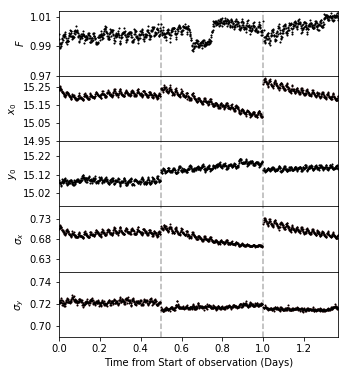

In [6]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(5, 6))
#fig.suptitle(planet+" Observation")

axes[0].plot(timep0[index], flux0[index],  'k.', markersize=1, alpha = 0.7)
axes[0].plot(timep, flux,  'k.', markersize=2, alpha = 1.0)
axes[0].set_ylabel("$F$")
axes[0].set_xlim((np.min(timep0), np.max(timep0)))
axes[0].set_yticks(np.arange(0.97, 1.01, 0.02))
axes[0].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[0].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[1].plot(timep0[index], xdata0[index],  'r.', markersize=1, alpha = 0.7)
axes[1].plot(timep, xdata,  'k.', markersize=2, alpha = 1.0)
axes[1].set_ylabel("$x_0$")
axes[1].set_yticks(np.arange(14.95, 15.25, 0.1))
axes[1].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[1].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[2].plot(timep0[index], ydata0[index],  'k.', markersize=1, alpha = 0.7)
axes[2].plot(timep, ydata, 'k.', markersize=2, alpha = 1.0)
axes[2].set_ylabel("$y_0$")
axes[2].set_yticks(np.arange(15.02, 15.30, 0.1))
axes[2].set_ylim((14.95, 15.3))
axes[2].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[2].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[3].plot(timep0[index], psfxw0[index],  'r.', markersize=1, alpha = 0.7)
axes[3].plot(timep, psfxw, 'k.', markersize=2, alpha = 1.0)
axes[3].set_ylabel("$\sigma _x$")
axes[3].set_yticks(np.arange(0.63, 0.77, 0.05))
axes[3].set_ylim((0.6, 0.76))
axes[3].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[3].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[4].plot(timep0[index], psfyw0[index],  'r.', markersize=1, alpha = 0.7)
axes[4].plot(timep, psfyw,  'k.', markersize=2, alpha = 1.0)
axes[4].set_ylabel("$\sigma_y$")
axes[4].set_ylim((0.69, 0.75))
axes[4].set_yticks(np.arange(0.70, 0.74, 0.02))
axes[4].set_xlabel('Time from Start of observation (Days)')
axes[4].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[4].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

fig.subplots_adjust(hspace=0)

#fig.tight_layout()
pathplot1 = foldername+'Raw_Measurements.pdf'
fig.savefig(pathplot1, bbox_inches='tight')

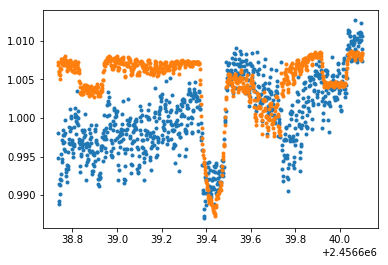

In [7]:
signaltest = helpers.signal(time, xdata, ydata, mid_x, mid_y, per, p0, mode)

plt.figure()
plt.plot(time, flux, '.')
plt.plot(time, signaltest, '.')
plt.show()

[ 1.00086266 -0.06205517  0.11141879 -1.03261379  0.82930145  0.09039097]


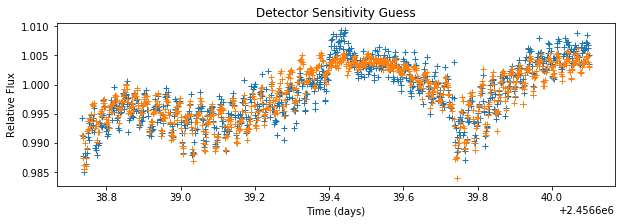

In [8]:
'''Adjust initial parameters'''
astro = astro_models.ideal_lightcurve(time, p0, per, mode)
resid = flux/astro

p0_detec, _ = scipy.optimize.curve_fit(helpers.detec_model_poly, (xdata, ydata, mid_x, mid_y, mode), resid, p0_detec)
# update p0
p0 = np.append(np.concatenate((p0_astro, p0_phase, p0_detec)), sigF)

D = helpers.detec_model_poly((xdata, ydata, mid_x, mid_y, mode), *p0_detec)

print(p0_detec)

plt.figure(figsize=(10,3))
#plt.plot(time, flux)
plt.plot(time, resid, '+')
plt.plot(time, D, '+')
plt.title('Detector Sensitivity Guess')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')
plt.show()

In [9]:
'''Getting ready for MCMC'''
print(helpers.lnprior(p0, initial, errs, time, per, mode))

# total nb steps
totalsteps = 0
# instruction for sampling
ndim, nwalkers = len(p0), 300
# get scattered starting point in parameter space 
pos = [p0*(1+1e-2*np.random.randn(ndim))+1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, 
                                args=((time, flux, xdata, ydata, mid_x, mid_y, per, initial, errs, mode)))

0.0


# Run MCMC

In [ ]:
tic = t.clock()
#Do firstnburn-in to get close to right answer
print('Running burn-in')
pos, lnp, _ = sampler.run_mcmc(pos, 2e3)
print("Mean burn-in acceptance fraction: {0:.3f}\n"
                .format(np.mean(sampler.acceptance_fraction)))
sampler.reset()

In [ ]:
##Continue from best spot from last time, and do quick burn-in to get walkers spread out
print("Running second burn-in")
pos = pos[np.argmax(lnp)]
#need to slightly change their positions, or they'll all take the same path
pos = [pos*(1+1e-3*np.random.randn(ndim))+1e-6*np.random.randn(ndim) for i in range(nwalkers)]
pos, _, _ = sampler.run_mcmc(pos, 2e3)
print("Mean burn-in acceptance fraction: {0:.3f}\n"
                .format(np.mean(sampler.acceptance_fraction)))
sampler.reset()

In [10]:
#Continue from where left off last time, and run production

print('Running production')
pos, _, _ = sampler.run_mcmc(pos, 2e3)
print("Mean acceptance fraction: {0:.3f}\n"
                .format(np.mean(sampler.acceptance_fraction)))
toc = t.clock()

print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))

Running production
Mean acceptance fraction: 0.354

MCMC runtime = 0.12 min



# Saving MCMC Results

In [11]:
pathchain = foldername + 'samplerchain_'+mode+'.npy'
pathposit = foldername + 'samplerposi_'+mode+'.npy'
#pathstate = foldername + 'samplerstate_'+mode+'.npy'
np.save(pathchain, sampler.chain)
np.save(pathposit, pos)
#np.save(pathstate, state)

In [12]:
#print the results
samples = sampler.chain.reshape((-1, ndim))

(MCMC_Results) = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0))))
p0_mcmc = np.median(samples, axis=0)

out = "MCMC result:\n\n"
for i in range(len(p0)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_names[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])

out += '{:>8} = {:>16}'.format('Offset', np.arctan(p0_mcmc[10]/p0_mcmc[9])*180/np.pi)

print(out)
with open(foldername+'MCMC_RESULTS_'+mode+'.txt','w') as file:
    file.write(out) 

MCMC result:

      t0 = 2456229.423104413  +6228.961847200058  -6984.295928133652
      rp = 0.11775945607189298  +0.000999294869345052  -0.00093778948653786
       a = 3.0369005488184078  +0.025305139054749404  -0.025930342205719548
     inc = 83.38727445001857  +0.7180280011788653  -0.6794287812695643
   ecosw = -2.0157683389122796e-07  +1.0049715238285145e-06  -8.747109469204033e-07
   esinw = 7.798523236219833e-08  +8.480705938255147e-07  -8.67122047626386e-07
      q1 = 0.4084742261222275  +0.0038675904821182105  -0.0036600863669978834
      q2 = 0.7833307639458144  +0.007016931450004704  -0.007010116077898476
      fp = 0.003994298122929765  +2.9357181474364002e-05  -3.204545140057975e-05
       A = 0.20010518705418165  +0.0018983355052371587  -0.0016814427900533613
       B = 1.0972977245482094e-08  +8.045264352602453e-07  -8.35563994625459e-07
      c1 = 1.0016638772646929  +0.008465393253130893  -0.008422216351668954
      c2 = -0.06205317504297757  +0.000497676649220645  -0.

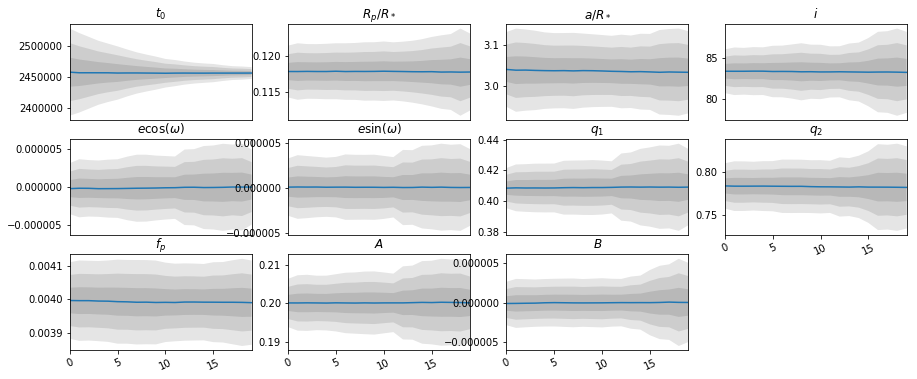

In [13]:
start = 11
if 'ellipse' in mode:
    start += 1
elif 'v2' in mode:
    start += 2
labels = p0_fancyNames[:start]

fname = foldername+'MCMC_RESULTS_'+mode+'_astroWalkers.pdf'
helpers.walk_style(start, nwalkers, sampler.chain, 1, 20, labels, fname)

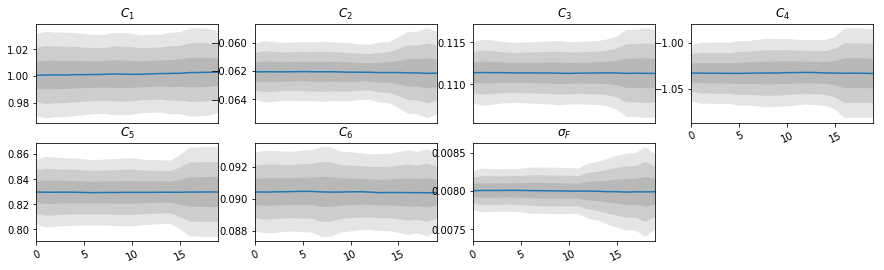

In [14]:
labels = p0_fancyNames[start:]
fname = foldername+'MCMC_RESULTS_'+mode+'_detecWalkers.pdf'
helpers.walk_style(len(p0)-start, nwalkers, sampler.chain[:,:,start:], 1, 20, labels, fname)

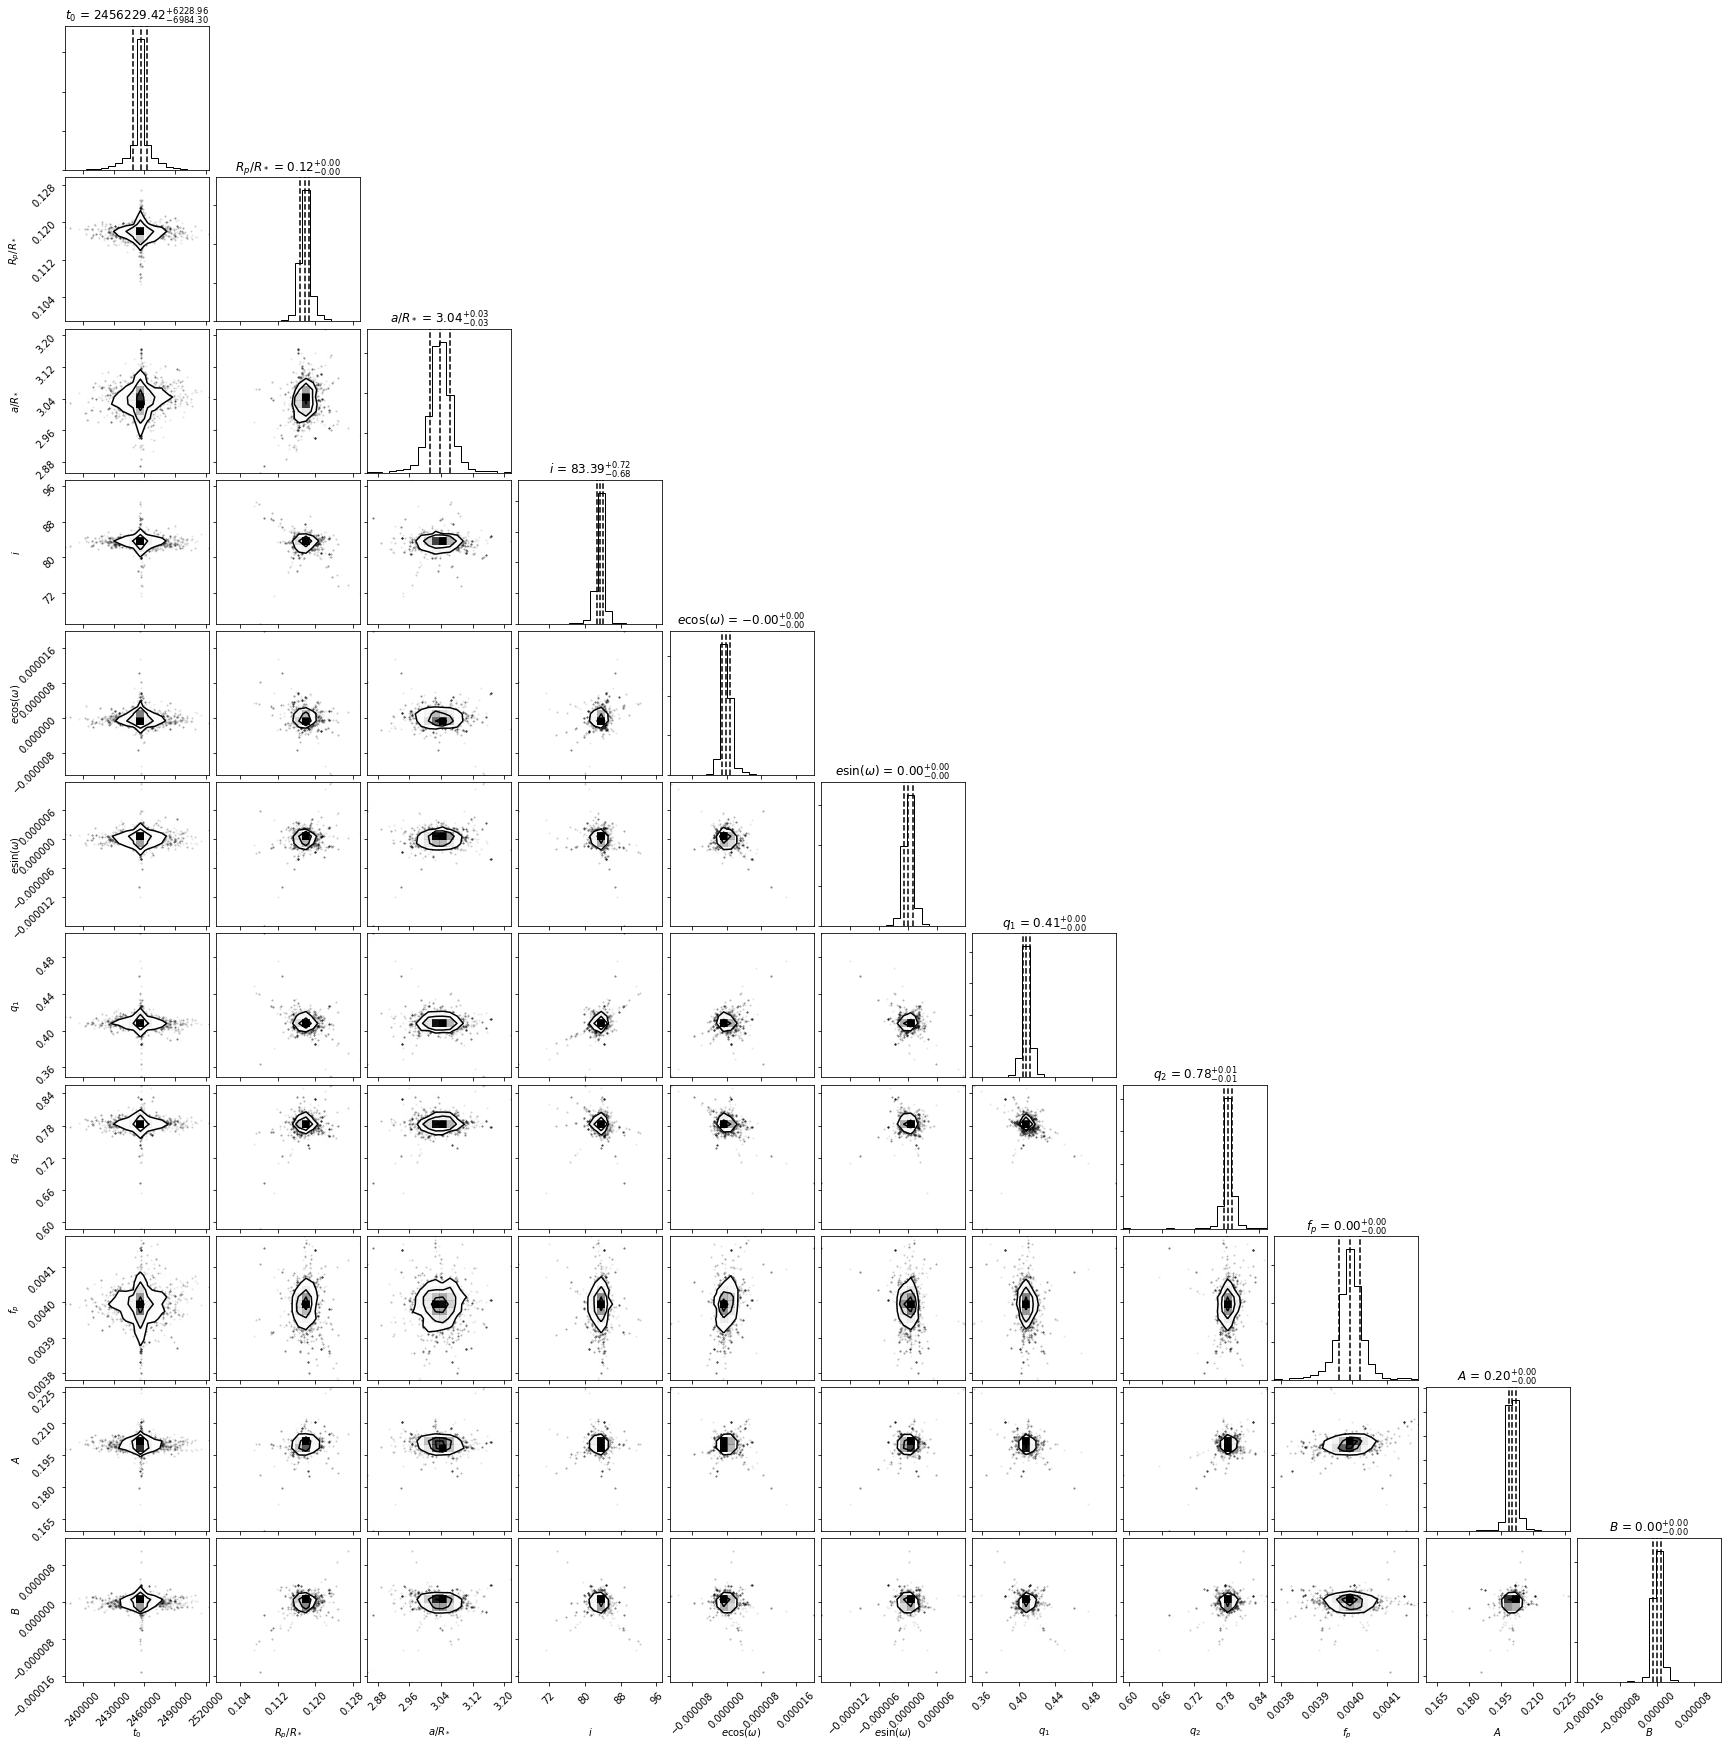

In [18]:
end = 11
if 'ellipse' in mode:
    end += 1
elif 'v2' in mode:
    end += 2
fig = corner.corner(samples[:,:end], labels=p0_fancyNames, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plotname = foldername + 'MCMC_'+mode+'_3.pdf'
fig.savefig(plotname, bbox_inches='tight')

#Clean out the RAM
samples = None
sampler = None

In [15]:
time2 = np.linspace(np.min(time), np.max(time), 1000)
mcmc_det = helpers.detec_model_poly((xdata, ydata, mid_x, mid_y, mode), *(p0_mcmc[start:-1]))
mcmc_lightplot = astro_models.ideal_lightcurve(time2, p0_mcmc, per, mode)
mcmc_lightcurve = astro_models.ideal_lightcurve(time, p0_mcmc, per, mode)

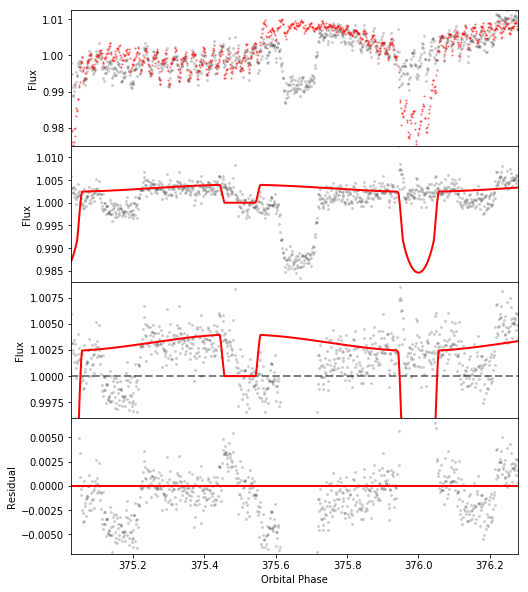

In [16]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 10))
axes[0].set_xlim((np.min(time)-p0_mcmc[0])/per, (np.max(time)-p0_mcmc[0])/per)
axes[0].plot((time-p0_mcmc[0])/per, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[0].plot((time-p0_mcmc[0])/per, mcmc_lightcurve*mcmc_det, '.', color = 'r', markersize = 2.5, alpha = 0.4)
axes[0].set_ylim(0.975, 1.0125)
axes[0].set_ylabel('Flux')

axes[1].plot((time-p0_mcmc[0])/per, flux/mcmc_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[1].plot((time-p0_mcmc[0])/per, mcmc_lightcurve, color = 'r', linewidth=2)
axes[1].set_ylabel('Flux')
axes[1].set_ylim(0.9825, 1.0125)
axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
axes[2].plot((time-p0_mcmc[0])/per, flux/mcmc_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[2].plot((time-p0_mcmc[0])/per, mcmc_lightcurve, color = 'r', linewidth=2)
axes[2].set_ylabel('Flux')
axes[2].set_ylim(0.996, 1.009)

axes[3].plot((time-p0_mcmc[0])/per, flux/mcmc_det - mcmc_lightcurve, 'k.', markersize = 4, alpha = 0.15)
axes[3].axhline(y=0, color='r', linewidth = 2)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Orbital Phase')
axes[3].set_ylim(-0.007, 0.007)

fig.subplots_adjust(hspace=0)
plotname = foldername + 'MCMC_'+mode+'_2.pdf'
fig.savefig(plotname, bbox_inches='tight')

# Is $\chi ^2$ improving?

In [17]:
#Binned data
data = (flux/mcmc_det)
fit  = mcmc_lightcurve
err = np.ones(len(data))*p0_mcmc[-1]
chisB = helpers.chi2(data, fit, err)
logLB = helpers.loglikelihood(data, fit, err)
EB = helpers.BIC(logLB, ndim, len(data))


#Unbinned data
#nFrames = 64
if ignoreFrames != []:
    nFrames2 = nFrames - len(ignoreFrames)

'''Full Data'''
flux_full, ferr_full, time_full, x_full, y_full = helpers.get_full_data(foldername, filename)

time_full += 2400000.5

'''Order in chronological order'''
index = np.argsort(time_full)
flux_full = flux_full[index]
ferr_full = ferr_full[index]
time_full = time_full[index]
x_full    = x_full[index]
y_full    = y_full[index]

'''Sigma clip per data cube'''
flux_clean = []
x_clean    = []
y_clean    = []

for i in range(nCubes):
    beg = int(i*nFrames2)
    end = int((i+1)*nFrames2)
    flux_clean = np.ma.append(flux_clean, sigma_clip(flux_full[beg:end]))
    x_clean = np.ma.append(x_clean, sigma_clip(x_full[beg:end]))
    y_clean = np.ma.append(y_clean, sigma_clip(y_full[beg:end]))

'''Normalize flux'''
flux_clean = flux_clean/np.ma.median(flux_clean)

'''Get model'''
det_full = helpers.detec_model_poly((x_clean, y_clean, mid_x, mid_y, mode), *(p0_mcmc[start:-1]))

# properly remove centroid outliers
det_full = np.ma.masked_array(det_full, mask=(y_clean.mask+x_clean.mask))

lc_full  = astro_models.ideal_lightcurve(time_full, p0_mcmc, per, mode)

model_full = det_full*lc_full

'''Get Fitted Uncertainty'''
ferr_clean = np.ones(len(flux_clean))*p0_mcmc[-1]*np.sqrt(nFrames)
ferr_clean = np.ma.masked_array(ferr_clean, mask = model_full.mask)

N = len(model_full)-np.sum((model_full).mask)

chis = helpers.chi2(flux_clean, model_full, ferr_clean)
logL = helpers.loglikelihood(flux_clean, lc_full*det_full, ferr_clean)
E = helpers.BIC(logL, ndim, N)

out = """{0}
Likelihood: {1}
Evidence: {2}
$\chi ^2 = $ {3}
$\ln(L)=$ {4}
$E =${5}""".format(chisB, logLB, EB, chis, logL, E) 
with open(foldername+'EVIDENCE_'+mode+'.txt','w') as file:
    file.write(out)
print(out)

/usr/local/lib/python3.5/dist-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/usr/local/lib/python3.5/dist-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


655.0156844099993
Likelihood: 4061.2604156632055
Evidence: 3999.949309815608
$\chi ^2 = $ 1243.869168709319
$\ln(L)=$ 153584.8672906621
$E =$153486.45294998863


In [19]:
e_chain = np.sqrt(samples[:,4]**2 + samples[:,5]**2)
w_chain = np.arctan(samples[:,5]/samples[:,4])
u1_chain = 2*np.sqrt(samples[:,6]**2)*samples[:,7]
u2_chain = np.sqrt(samples[:,6]**2)*(1-2*samples[:,7])
binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)

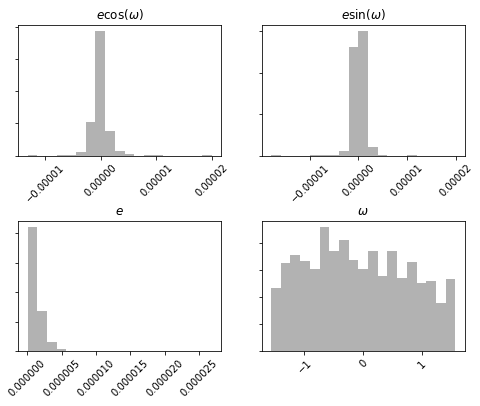

In [20]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,4], bins=np.linspace(np.min(samples[:,4]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,5], bins=np.linspace(np.min(samples[:,5]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
axes[1,0].set_title('$e$', fontsize=12)
axes[1,1].set_title('$\omega$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + 'MCMC_'+mode+'_5.pdf'
fig.savefig(plotname, bbox_inches='tight')

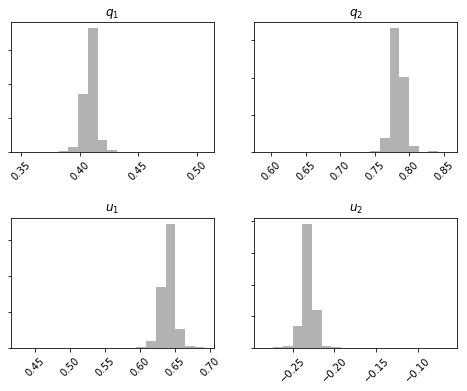

In [21]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,6], bins=np.linspace(np.min(samples[:,6]), np.max(samples[:,6]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,7], bins=np.linspace(np.min(samples[:,7]), np.max(samples[:,7]), 20), color='k', alpha=0.3)
axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$q_1$', fontsize=12)
axes[0,1].set_title('$q_2$', fontsize=12)
axes[1,0].set_title('$u_1$', fontsize=12)
axes[1,1].set_title('$u_2$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + 'MCMC_'+mode+'_6.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [22]:
ResultMCMC_Params = Table()

for i in range(len(p0_names)):
    ResultMCMC_Params[p0_names[i]] = MCMC_Results[i]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
ResultMCMC_Params['evidence'] = [E]

pathres = foldername + 'ResultMCMC_'+mode+'_Params.npy'
np.save(pathres, ResultMCMC_Params)

In [23]:
# determining in-eclipse and in-transit index

# generating transit model

(t0_mcmc, rp_mcmc, a_mcmc, inc_mcmc, ecosw_mcmc, esinw_mcmc, q1_mcmc, q2_mcmc, fp_mcmc) = p0_mcmc[:9]
ecc_mcmc = np.sqrt(ecosw_mcmc**2 + esinw_mcmc**2)
w_mcmc   = np.arctan2(esinw_mcmc, ecosw_mcmc)
u1_mcmc  = 2*np.sqrt(q1_mcmc)*q2_mcmc
u2_mcmc  = np.sqrt(q1_mcmc)*(1-2*q2_mcmc)

trans, t_sec, true_anom = astro_models.transit_model(time, t0_mcmc, per, rp_mcmc, 
                                                   a_mcmc, inc_mcmc, ecc_mcmc, w_mcmc,
                                                   u1_mcmc, u2_mcmc)
# generating secondary eclipses model
eclip = astro_models.eclipse(time, t0_mcmc, per, rp_mcmc, a_mcmc, inc_mcmc, ecc_mcmc, w_mcmc,
                           u1_mcmc, u2_mcmc, fp_mcmc, t_sec)

# get in-transit indices
ind_trans  = np.where(trans!=1)
# get in-eclipse indices
ind_eclip  = np.where((eclip!=(1+fp_mcmc)))
# seperating first and second eclipse
ind_ecli1 = ind_eclip[0][np.where(ind_eclip[0]<int(len(time)/2))]
ind_ecli2 = ind_eclip[0][np.where(ind_eclip[0]>int(len(time)/2))]

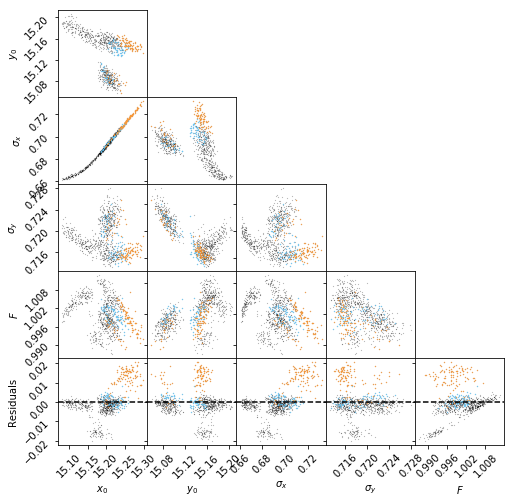

In [24]:
residual = flux/mcmc_det - mcmc_lightcurve

data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecli1], ydata[ind_ecli1], psfxw[ind_ecli1], psfyw[ind_ecli1], flux[ind_ecli1], residual[ind_ecli1]]
data3 = [xdata[ind_trans], ydata[ind_trans], psfxw[ind_trans], psfyw[ind_trans], flux[ind_trans], residual[ind_trans]]
data4 = [xdata[ind_ecli2], ydata[ind_ecli2], psfxw[ind_ecli2], psfyw[ind_ecli2], flux[ind_ecli2], residual[ind_ecli2]]
label = ['$x_0$', '$y_0$', '$\sigma _x$', '$\sigma _y$', '$F$', 'Residuals']

plotname = foldername + 'MCMC_'+mode+'_7.pdf'
helpers.triangle_colors(data1, data2, data3, data4, label, plotname)